In [1]:
import numpy as np
from pymultifracs import mfa
import matplotlib.pyplot as plt
from pymultifracs.simul import mrw
import pandas as pd
from pymultifracs.utils import build_q_log
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [2]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
import sweetviz as sv

In [3]:
H1 = 0.8
H2 = 0.3

lamdba1 = .17
lamdba2 = .17

n_per_class = 1000
length = 2048 #65536
L = length
X1 =  mrw(shape=(length,n_per_class), H=H1, lam=lamdba1, L=L).T
X2 =  mrw(shape=(length,n_per_class), H=H2, lam=lamdba2, L=L).T

In [4]:
# data = np.load('hrv_data_good.npy')
data = np.load('better_hrv_data.npy')
X, y = data[:,:-1], data[:,-1]

In [5]:
X1 = X[np.where(1-y)]
X2 = X[np.where(y)]

In [6]:
X1.shape

(200, 25000)

In [7]:
# result = {'Transformation (shape)': trans_name_str}
#         result["shape"] = trans_X.shape[-1]
#         result['nb_trans'] = len(trans)

#         scaler = StandardScaler()
#         trans_X = scaler.fit_transform(trans_X) 
#         print(f"Transformation: {trans_name_str}, Shape: {trans_X.shape[-1]} ")
#         for clf_name, clf in classifiers.items():
#             kf = KFold(n_splits=5, shuffle=True, random_state=42)
#             scores = cross_val_score(clf, trans_X, y, cv=kf, scoring='accuracy')
#             result[f'{clf_name} accuracy'] = np.mean(scores)
#             result[f'{clf_name} std'] = np.std(scores)
#             print(f"Classifier: {clf_name}, "
#                   f"Mean Accuracy: {np.mean(scores):.3f}, Std Accuracy: {np.std(scores):.3f}")
        
#         results.append(result)

In [8]:
signal = X1[0]
dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(2, 4)],
        q=[-10, -5, 0, 5, 10],
        n_cumul=2,
        p_exp=np.inf,
        gamint=0.0
        )
lwt_sf, lwt_cumul, lw_mfs, lwt_hmin = lwt
sf, cumul, mfs, hmin = dwt


c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:87: RuntimeWarning: divide by zero encountered in power
  return np.power(array, exponent)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\cumulants.py:265: RuntimeWarning: divide by zero encountered in log
  log_T_X_j = np.log(T_X_j)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:117: RuntimeWarning: invalid value encountered in divide
  R_j = temp / Z
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning: divide by zero encountered in log2
  V[:, ind_j, :] = fixednansum(R_j * np.log2(mrq_values_j), axis=1)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning: invalid value encountered in multiply
  V[:, ind_j, :] = fixednansum(R_j * np.log2(mrq_values_j), axis=1)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.

In [9]:
lwt_cumul.log_cumulants

array([[[ 0.29305523]],

       [[-0.12113891]]])

In [10]:
hmin

array([[-0.39411642]])

In [11]:
def get_df_mfa(signals, n_cumul=2, j1=2, j2=7):
    results = []
    for signal in signals:
        result = dict()
        dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(j1, j2)],
        q= [-10, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 10], #[-10, -5,-3,-2, 0,2,3, 5, 10], #[-4,-3,-2,1,0,1,2,3,4],# [-10, -5, -2, 0, 2, 5, 10],#build_q_log(1, 10, 20), # q=[-10, -5, 0, 5, 10],
        n_cumul=n_cumul,
        p_exp=np.inf,
        gamint=0.0
        )
        lwt_sf, lwt_cumul, lwt_mfs, lwt_hmin = lwt
        sf, cumul, mfs, hmin = dwt

        def get_item(arr):
            return arr.item() if isinstance(arr,np.ndarray) else lwt_hmin

        result['std'] = signal.std()
        result['hmin'] = hmin.item()
        result['l_hmin'] = get_item(lwt_hmin) # lwt_hmin.item() if isinstance(lwt_hmin,np.ndarray) else lwt_hmin

        result['deg_h'] = mfs.hq.max() - mfs.hq.min()
        result['l_deg_h'] = lwt_mfs.hq.max() - lwt_mfs.hq.min()
        result['H'] = get_item(sf.H)
        result['l_H'] = get_item(lwt_sf.H)

        for i in range(n_cumul):
            result[f'cumul{i}'] = get_item(cumul.log_cumulants[i])
            result[f'l_cumul{i}'] = get_item(lwt_cumul.log_cumulants[i])
        
        for i in range(sf.zeta.shape[0]):
            result[f' zeta(q={sf.q[i]})'] = sf.zeta[i, 0, 0]
            result[f' zeta(q={lwt_sf.q[i]})'] = lwt_sf.zeta[i, 0, 0]

        results.append(result)
    return pd.DataFrame(results)

In [12]:
# sf.H

In [13]:
n_cumul = 4

In [14]:
scaler = StandardScaler()

In [15]:
df_mfa1 = get_df_mfa(X1, n_cumul=n_cumul)
ndf_mfa1 = get_df_mfa(scaler.fit_transform(X1), n_cumul=n_cumul)
df_mfa2 = get_df_mfa(X2, n_cumul=n_cumul)
ndf_mfa2 = get_df_mfa(scaler.fit_transform(X2), n_cumul=n_cumul)
columns = df_mfa1.columns

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:76: RuntimeWarning: divide by zero encountered in reciprocal
  return array ** exponent
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:87: RuntimeWarning: divide by zero encountered in power
  return np.power(array, exponent)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:76: RuntimeWarning: divide by zero encountered in reciprocal
  return array ** exponent
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\cumulants.py:265: RuntimeWarning: divide by zero encountered in log
  log_T_X_j = np.log(T_X_j)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:117: RuntimeWarning: invalid value encountered in divide
  R_j = temp / Z
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning: divide by zero encountered in log2
  V[:, ind_j, :] = fixedna

In [17]:
combined_df

,A,B,Source
0,1,4,df1
1,2,5,df1
2,3,6,df1
3,7,10,df2
4,8,11,df2
5,9,12,df2


In [19]:
# report = sv.analyze(df_mfa1)

# report.show_html('df_mfa1.html')

                                             |          | [  0%]   00:00 -> (? left)

Report df_mfa1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [20]:
# report = sv.analyze(df_mfa2)

# report.show_html('df_mfa2.html')

                                             |          | [  0%]   00:00 -> (? left)

Report df_mfa2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [21]:
df_mfa1.describe() # include='all')

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.175974,-0.447242,1.415055,0.656378,-0.290803,0.216460,-0.204318,0.335791,-0.108894,-0.131196,...,-1.773418,-1.274178,-0.817579,-0.386830,0.268871,0.432920,0.546049,0.633623,0.702590,0.875323
std,0.078678,0.139749,0.862591,0.245038,0.179096,0.072653,0.241843,0.151013,0.174505,0.191530,...,0.867368,0.624722,0.395376,0.180633,0.110487,0.145307,0.139976,0.130311,0.122354,0.126678
min,0.043469,-0.944844,0.356901,0.341295,-0.530645,0.114918,-0.602670,0.150628,-0.778573,-0.754136,...,-4.523868,-3.215942,-2.057490,-0.914164,0.136783,0.229836,0.293283,0.347402,0.394997,-0.272043
25%,0.119381,-0.538309,0.940675,0.495315,-0.424933,0.170228,-0.421888,0.207549,-0.207218,-0.252266,...,-1.969920,-1.506009,-1.048394,-0.519860,0.187324,0.340457,0.461710,0.556264,0.633314,0.827204
50%,0.163134,-0.461598,1.281372,0.585399,-0.340023,0.190926,-0.254618,0.276444,-0.050618,-0.044177,...,-1.498394,-1.061646,-0.718834,-0.358467,0.213820,0.381851,0.515245,0.618539,0.700051,0.899419
75%,0.218726,-0.366833,1.626504,0.710412,-0.182973,0.254589,0.005552,0.466608,0.010325,-0.025681,...,-1.137077,-0.789290,-0.475003,-0.222061,0.337862,0.509179,0.595280,0.684199,0.763625,0.956432
max,0.428472,0.124148,6.719287,1.569768,0.377531,0.488023,0.354654,0.749550,0.295014,0.268965,...,-0.693029,-0.522455,-0.370125,-0.172398,0.597792,0.976046,1.005397,1.025162,1.034966,1.072266


In [22]:
# ndf_mfa1.describe() # include='all')

In [23]:
df_mfa2.describe()

,std,hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,l_cumul1,...,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=-1),zeta(q=1),zeta(q=2),zeta(q=3),zeta(q=4),zeta(q=5),zeta(q=10)
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.114522,-0.307844,1.417627,0.635747,-0.079396,0.306671,-0.002849,0.402467,-0.040736,-0.041639,...,-1.804232,-1.303972,-0.845249,-0.415027,0.367822,0.613342,0.733783,0.794611,0.832419,0.919972
std,0.055070,0.107961,0.526381,0.127101,0.085396,0.069892,0.095508,0.094076,0.111072,0.097193,...,0.384224,0.285023,0.191872,0.095618,0.087539,0.139783,0.151828,0.149605,0.142529,0.112094
min,0.050677,-0.653612,0.428884,0.346970,-0.303888,0.087840,-0.312478,0.097445,-0.328023,-0.312991,...,-2.854079,-2.063191,-1.344288,-0.670440,0.091672,0.175681,0.254257,0.308463,0.353498,0.513986
25%,0.080928,-0.386666,0.999365,0.553552,-0.129297,0.279316,-0.063511,0.334580,-0.113097,-0.103375,...,-2.135897,-1.520690,-0.943744,-0.484125,0.331439,0.558631,0.687610,0.757291,0.798275,0.901631
50%,0.097064,-0.297716,1.355628,0.612105,-0.084638,0.323242,0.012036,0.406205,-0.039352,-0.004687,...,-1.725019,-1.270119,-0.830386,-0.408813,0.377985,0.646485,0.785356,0.839976,0.877702,0.963979
75%,0.127838,-0.233846,1.742276,0.720340,-0.022087,0.350967,0.064830,0.469855,0.031193,0.030745,...,-1.507842,-1.067697,-0.704230,-0.348069,0.433543,0.701934,0.827174,0.889533,0.926086,0.990318
max,0.374423,-0.001342,3.376963,1.042510,0.148506,0.473293,0.199914,0.599442,0.291810,0.103127,...,-1.099379,-0.775418,-0.329455,-0.110611,0.529187,0.946587,1.004594,1.008417,1.008618,1.064326


In [24]:
# ndf_mfa2.describe() 

In [25]:
df1 = df_mfa1.copy()
df2 = df_mfa2.copy()
# # Generate the Sweetviz report
# report = sv.compare([df1, "LEFT"], [df2, "RIGHT"])

# # Show the report
# report.show_html('Comparison_Report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Comparison_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [26]:

df1.columns = ['LEFT_' + col for col in df_mfa1.columns]
df2.columns = ['RIGHT_' + col for col in df_mfa2.columns]
# Interleave the columns
combined_df = pd.concat([df1, df2], axis=1)
combined_df = combined_df[[col for pair in zip(df1.columns, df2.columns) for col in pair]]

report = sv.analyze(combined_df)

report.show_html('combined_df.html')

                                             |          | [  0%]   00:00 -> (? left)

Report combined_df.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [27]:
stop

NameError: name 'stop' is not defined

In [ ]:
def get_mfa_representation(signals, n_cumul=2):
    representations = []
    for signal in signals:
        representation = []
       
        dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(2, 4)],
        q= [-10, -5, -2, 0, 2, 5, 10],#build_q_log(1, 10, 20), # q=[-10, -5, 0, 5, 10],
        n_cumul=n_cumul,
        p_exp=np.inf,
        gamint=0.0
        )
        lwt_sf, lwt_cumul, lwt_mfs, lwt_hmin = lwt
        sf, cumul, mfs, hmin = dwt

        def get_item(arr):
            return arr.item() if isinstance(arr,np.ndarray) else lwt_hmin

        representation.append(signal.std())

        representation.append(lwt_mfs.hq.max() - lwt_mfs.hq.min())
        representation.append(lwt_sf.H.item())

        for i in range(n_cumul):
            representation.append(lwt_cumul.log_cumulants[i].item())
            
        representations.append(representation)
    return np.array(representations)

In [ ]:
# X_mfa = get_mfa_representation(scaler.fit_transform(X),n_cumul=3)
X_df = get_df_mfa(X, n_cumul=3)
columns = X_df.columns
X_mfa = np.array(X_df,dtype = np.float32)

FloatingPointError: divide by zero encountered in power

In [ ]:
np.isnan(X_mfa)

array([[False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [ ]:
X_mfa[np.where(np.isnan(X_mfa))] = 0.

In [ ]:
# x1 = np.array(df_mfa1)
# y1 = np.zeros((x1.shape[0],1))
# x2 = np.array(df_mfa2)
# y2 = np.zeros((x2.shape[0],1))

# x = np.concatenate([x1,x2],axis=0)
# y = np.concatenate([y1,y2],axis=0)


In [ ]:
# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mfa, y, test_size=0.2, random_state=42)

In [ ]:
svc = SVC(kernel='linear')
scaler = StandardScaler()
# nX_mfa = scaler.fit_transform(X_train)
svc.fit(X_train,y_train)

SVC(kernel='linear')

               Weight
std         -0.297508
hmin         1.384380
l_hmin       0.000000
deg_h       -0.399250
l_deg_h      0.384603
H            1.538249
l_H          0.516897
cumul0       1.914746
l_cumul0     0.101372
cumul1       1.151998
l_cumul1     1.138719
cumul2       0.248382
l_cumul2    -0.086547
 zeta(q=-4) -0.238244
 zeta(q=-3)  0.126826
 zeta(q=-2)  0.358384
 zeta(q=1)   0.446388
 zeta(q=0)   0.000000
 zeta(q=2)   1.033795
 zeta(q=3)   0.818204
 zeta(q=4)  -0.328744
0.8142857142857143


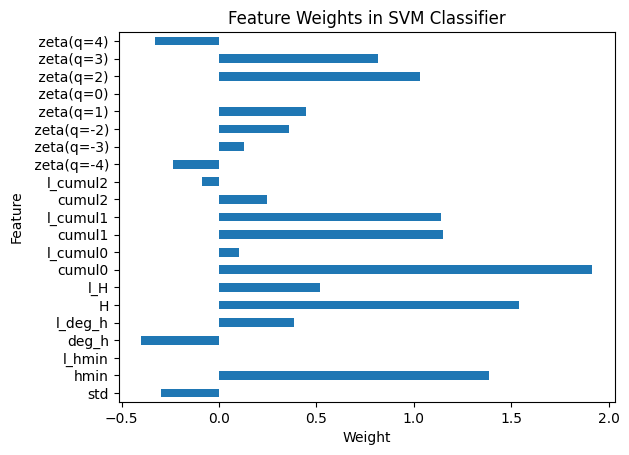

In [ ]:
# Step 5: Access and Analyze Weights
# The coefficients (weights) of the features for a linear SVM
weights = svc.coef_

# For visualization purposes
features = columns # ['std','deg_h','H'] + [f'cumul{i}' for i in range(X_mfa.shape[-1] - 3)]
weights_df = pd.DataFrame(weights.T, index=features, columns=['Weight'])
print(weights_df)
print( accuracy_score(y_test, svc.predict(X_test)))
# Step 6: Visualize Weights
weights_df.plot(kind='barh', legend=False)
plt.title('Feature Weights in SVM Classifier')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()

In [ ]:
X_df

,std,hmin,l_hmin,deg_h,l_deg_h,H,l_H,cumul0,l_cumul0,cumul1,...,cumul2,l_cumul2,zeta(q=-4),zeta(q=-3),zeta(q=-2),zeta(q=1),zeta(q=0),zeta(q=2),zeta(q=3),zeta(q=4)
0,0.141923,-0.648819,None,1.326101,0.546756,-0.371914,0.214263,-0.390692,0.230693,0.031582,...,0.199980,0.026125,-1.625450,-1.023577,-0.568525,0.221706,0.0,0.428525,0.609035,0.746263
1,0.061123,-0.383863,None,1.695821,0.497616,0.127625,0.416279,0.192217,0.409463,0.029704,...,0.058390,0.134304,-1.352790,-1.017114,-0.690539,0.479688,0.0,0.832558,0.899434,0.920452
2,0.065726,-0.456852,None,2.197582,0.441078,0.140833,0.388696,0.306947,0.464772,-0.039770,...,0.151648,0.039457,-1.757232,-1.303033,-0.866993,0.486081,0.0,0.777391,0.827134,0.851398
3,0.141240,0.130572,None,6.409231,0.959680,0.440623,0.432314,0.445516,0.440510,-0.081368,...,2.815290,0.008243,-2.420150,-1.523213,-0.830525,0.467602,0.0,0.864628,0.934412,0.877926
4,0.121686,-0.454131,None,1.458187,0.825746,-0.304856,0.236739,-0.157091,0.688041,-0.161651,...,-0.120670,-0.416640,-3.583771,-2.760646,-1.883538,0.368159,0.0,0.473478,0.561179,0.654480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.109085,-0.315899,None,1.541993,0.628020,-0.091783,0.312037,0.001876,0.510158,0.027605,...,-0.328244,-0.174293,-2.362046,-1.717325,-1.128417,0.415960,0.0,0.624074,0.719707,0.779856
342,0.212618,-0.219582,None,1.115271,0.804666,-0.087075,0.164084,0.008394,0.282964,0.048106,...,-0.758358,0.175698,-2.695365,-1.846514,-1.064938,0.204200,0.0,0.328168,0.422165,0.499119
343,0.071377,-0.409108,None,1.371308,0.517620,-0.035872,0.359703,0.072954,0.444812,-0.124062,...,0.090850,-0.032660,-1.990387,-1.455428,-0.942976,0.418866,0.0,0.719405,0.851576,0.895864
344,0.127784,-0.287147,None,1.063376,0.786802,-0.113099,0.259703,-0.045806,0.383612,-0.151145,...,0.288486,0.065042,-2.844573,-1.972842,-1.153852,0.311786,0.0,0.519406,0.667406,0.778079


acc_on_test:  0.8142857142857143


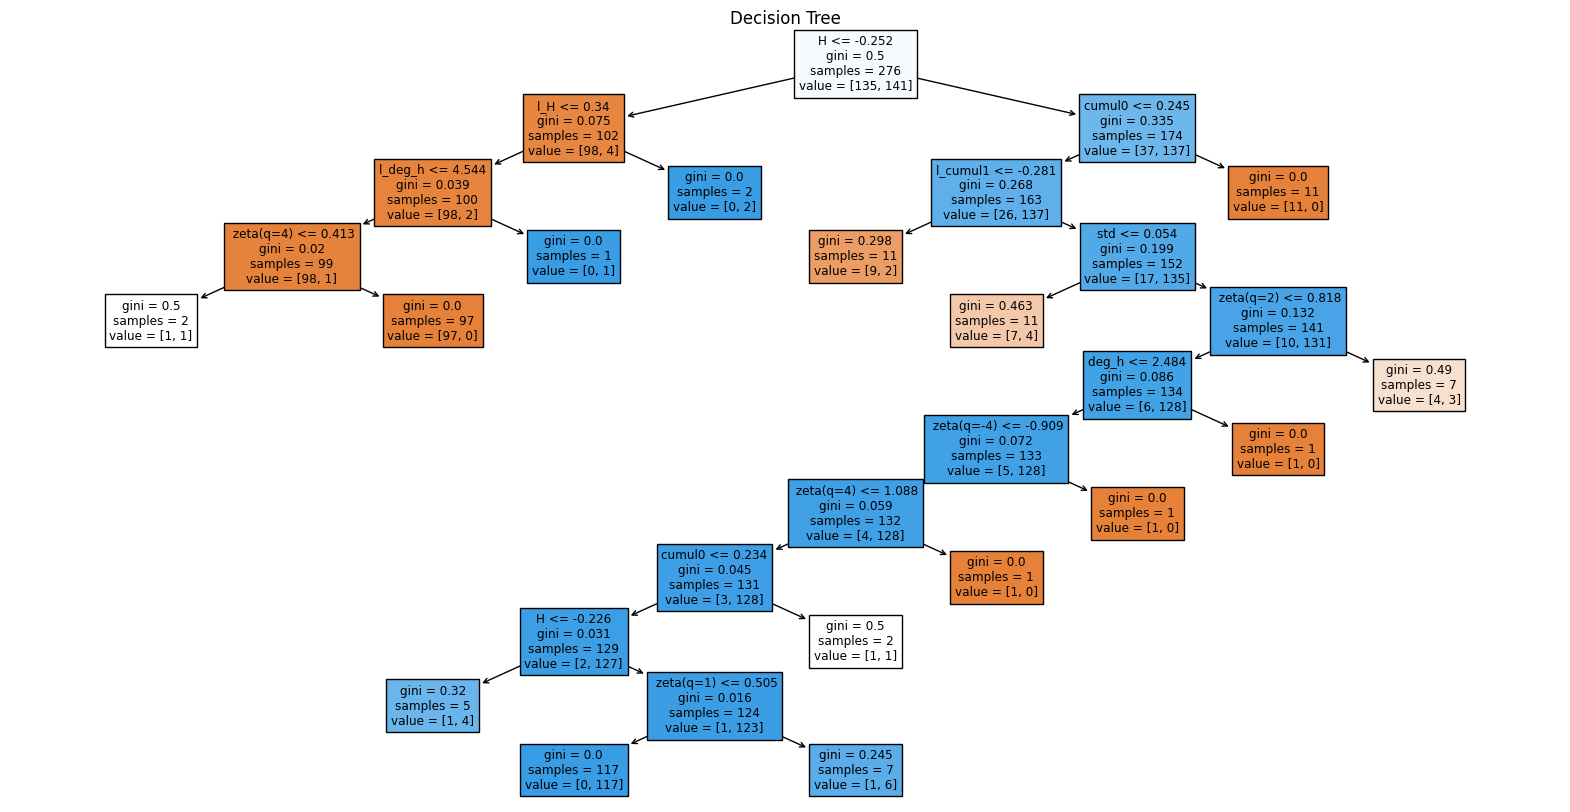

In [ ]:


# Step 2: Load Dataset
# Using Iris dataset for demonstration purposes




# Step 4: Train the Model
clf = DecisionTreeClassifier(min_samples_split=30)
clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test,clf.predict(X_test))
print('acc_on_test: ', accuracy)
# Step 5: Visualize the Tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=features, filled=True)
plt.title('Decision Tree')
plt.show()


In [ ]:
stop

NameError: name 'stop' is not defined

          Weight
std    -0.123146
deg_h  -0.102553
H       1.415173
cumul0 -0.260283
cumul1 -0.382676
cumul2  2.077919


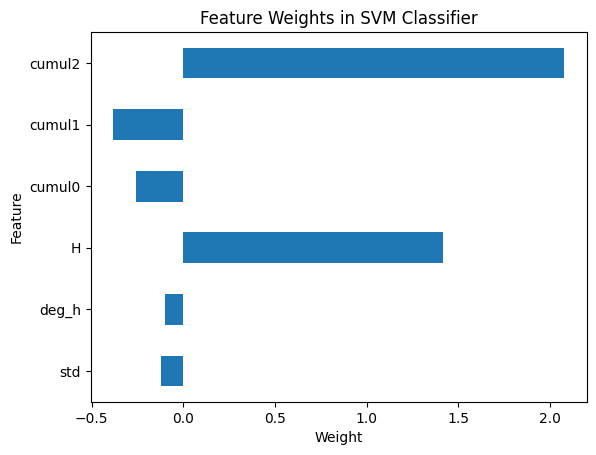

In [ ]:
# Step 5: Access and Analyze Weights
# The coefficients (weights) of the features for a linear SVM
weights = svc.coef_

# For visualization purposes
features = ['std','deg_h','H'] + [f'cumul{i}' for i in range(X_mfa.shape[-1] - 3)]
weights_df = pd.DataFrame(weights.T, index=features, columns=['Weight'])
print(weights_df)

# Step 6: Visualize Weights
weights_df.plot(kind='barh', legend=False)
plt.title('Feature Weights in SVM Classifier')
plt.xlabel('Weight')
plt.ylabel('Feature')
plt.show()

c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\utils.py:87: RuntimeWarning: divide by zero encountered in power
  return np.power(array, exponent)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\cumulants.py:265: RuntimeWarning: divide by zero encountered in log
  log_T_X_j = np.log(T_X_j)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:117: RuntimeWarning: invalid value encountered in divide
  R_j = temp / Z
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning: divide by zero encountered in log2
  V[:, ind_j, :] = fixednansum(R_j * np.log2(mrq_values_j), axis=1)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.py:118: RuntimeWarning: invalid value encountered in multiply
  V[:, ind_j, :] = fixednansum(R_j * np.log2(mrq_values_j), axis=1)
c:\users\ant\documents\info2\bits2beat-tests\pymultifracs\pymultifracs\mfspectrum.

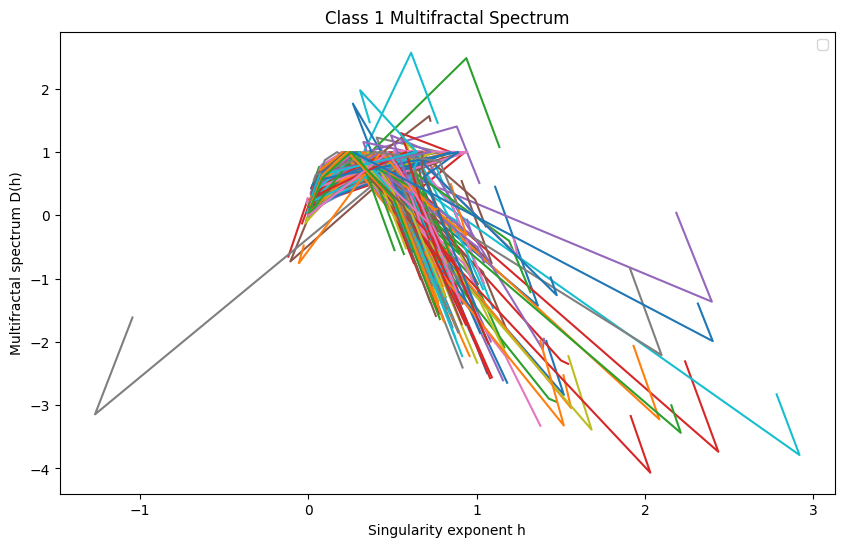

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


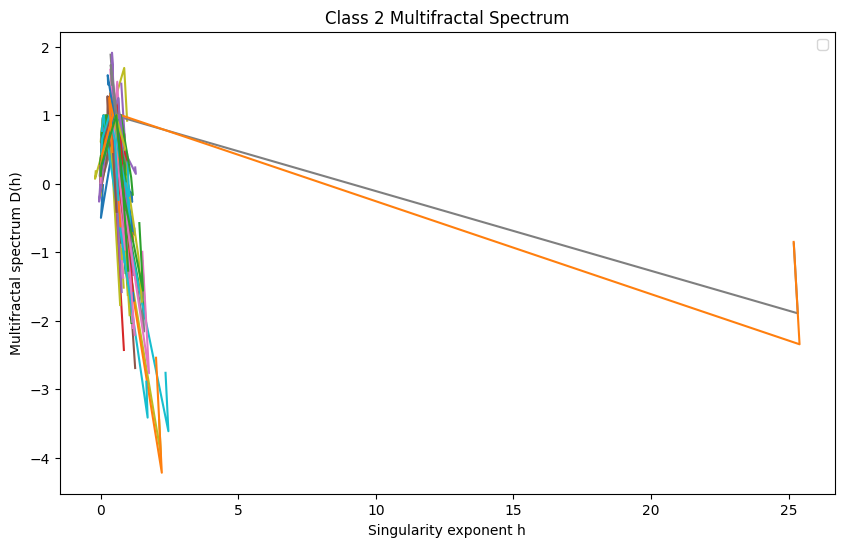

Signal 1 - Class 1: h_min = 0.004789327047044767, h_max = 1.3635323796476395
Signal 1 - Class 2: h_min = 0.011654772813882941, h_max = 0.8774391472157497
--------------------------------------------------
Signal 2 - Class 1: h_min = 0.003879474228292157, h_max = 0.7978281426260496
Signal 2 - Class 2: h_min = 0.028183834390549833, h_max = 0.7837668898386774
--------------------------------------------------
Signal 3 - Class 1: h_min = 0.014126140034758872, h_max = 0.6681639640270349
Signal 3 - Class 2: h_min = 0.011468298381872799, h_max = 0.6781920449932723
--------------------------------------------------
Signal 4 - Class 1: h_min = -0.014231087837635714, h_max = 2.435971229436213
Signal 4 - Class 2: h_min = 0.004982309993013634, h_max = 0.9575871074662796
--------------------------------------------------
Signal 5 - Class 1: h_min = 0.011097109774360181, h_max = 0.871685528496541
Signal 5 - Class 2: h_min = 0.009355065432377185, h_max = 1.0547433684040048
---------------------------

In [ ]:

# Step 2: Load the signals
# Assume we have two lists of signals, class1_signals and class2_signals
# Here, we generate some synthetic data for illustration purposes

# Generating synthetic data for two classes
np.random.seed(0)
# class1_signals = [np.cumsum(np.random.randn(1000)) for _ in range(10)]  # Random walk signals
# class2_signals = [np.cumsum(np.random.randn(1000) + 0.5) for _ in range(10)]  # Biased random walk signals

class1_signals = X1
class2_signals = X2
# Function to perform multifractal analysis
def perform_multifractal_analysis(signals):
    results = []
    for signal in signals:
        dwt, lwt = mfa.mf_analysis_full(
        signal,
        scaling_ranges=[(2, 4)],
        q=[-10, -5, 0, 5, 10],
        n_cumul=2,
        p_exp=np.inf,
        gamint=0.0
    )
        
        sf, cumul, mfs, hmin = lwt
        mf_analysis = mfs
    #         mf_analysis = MFAnalysis(signal, n_cumul=2, q=[-10, -5, 0, 5, 10])
    #         mf_analysis.analyze()
        results.append(mf_analysis)
    return results

# Step 3: Perform multifractal analysis
class1_results = perform_multifractal_analysis(class1_signals)
class2_results = perform_multifractal_analysis(class2_signals)

# Step 4: Compare characteristics
# Extracting and plotting the multifractal spectrum for the first signal in each class as an example

def plot_multifractal_spectrum(results, title):
    plt.figure(figsize=(10, 6))
    for result in results:
        spectrum = result
        plt.plot(spectrum.hq.squeeze(), spectrum.Dq.squeeze())#, label='Signal')
    plt.xlabel('Singularity exponent h')
    plt.ylabel('Multifractal spectrum D(h)')
    plt.title(title)
    plt.legend()
    plt.show()

# Plotting the multifractal spectrum for the first signal in each class
plot_multifractal_spectrum(class1_results, 'Class 1 Multifractal Spectrum')
plot_multifractal_spectrum(class2_results, 'Class 2 Multifractal Spectrum')

# Compare other characteristics like the Hölder exponents, scaling functions, etc.
def compare_characteristics(class1_results, class2_results):
    # Extract and compare characteristics
    for i, (res1, res2) in enumerate(zip(class1_results, class2_results)):
        h_min1, h_max1 = res1.hq.min(), res1.hq.max()
        h_min2, h_max2 = res2.hq.min(), res2.hq.max()
        print(f'Signal {i + 1} - Class 1: h_min = {h_min1}, h_max = {h_max1}')
        print(f'Signal {i + 1} - Class 2: h_min = {h_min2}, h_max = {h_max2}')
        print('-' * 50)

compare_characteristics(class1_results, class2_results)
